In [1]:
# !wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
# !wget -q https://github.com/DM-GY-9103-2024F-H/WK14/raw/main/WK14_utils.py

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, Tensor

from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import vgg19, VGG19_Weights
from torchvision.transforms import v2

from image_utils import make_image, open_image

## 3. Deep dream with black input

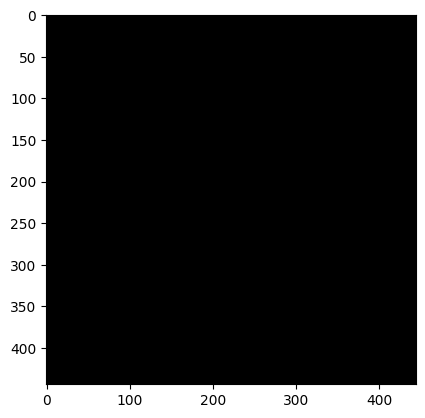

In [3]:
original_img = np.zeros((444, 444, 3))
plt.imshow(original_img)

In [4]:
img_mean = Tensor([0.485, 0.456, 0.406])
img_std = Tensor([0.229, 0.224, 0.225])
img_unmean = img_mean.reshape(3,1,1)
img_unstd = img_std.reshape(3,1,1)

def unprocess_image(img_t, scale=1):
  img_t = img_t * img_unstd + img_unmean
  img_t = img_t.squeeze().permute(1, 2, 0)
  img_t = scale * img_t.clip(0.0, 1.0)
  return img_t

def clip_norm(device="cpu"):
  img_unmean = img_mean.reshape(3,1,1).to(device)
  img_unstd = img_std.reshape(3,1,1).to(device)
  def _clip_norm(img_t):
    return img_t.clip(-img_unmean / img_unstd, (1 - img_unmean) / img_unstd)
  return _clip_norm

In [5]:
process_transform = v2.Compose([
  v2.Resize(512),
  v2.ToImage(),
  v2.ConvertImageDtype(torch.float),
  v2.Normalize(img_mean, img_std)
])

# Create Tensor for NN
original_t = process_transform(original_img).unsqueeze(0)

In [6]:
def make_deep_dream(original_t, model, lr):
    """
    Apply deep dream model using select layers of VGG19 

    Args:
        orginal_t: input image that is passed through process_transform()
        model: subset of pre-trained VGG19, i.e. first X layers of VGG19
        lr: pre-defined learning rate.
    """

    model_vgg = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
    # layers = list(model_vgg.children())

    ClipNorm = clip_norm(mdevice)

    out = model(original_t.to(mdevice))

    input_image = original_t.clone().to(mdevice)
    input_image.requires_grad_(True)

    for e in range(10):
        model.zero_grad()
        out = model(input_image)
        loss = out.norm()
        loss.backward()

        avg_grad = input_image.grad.data.cpu().abs().mean()
        norm_lr = lr / avg_grad

        input_image.data += norm_lr * input_image.grad.data
        input_image.data = ClipNorm(input_image.data)
        input_image.grad.data.zero_()
    
    output_image = make_image(unprocess_image(input_image.to("cpu"), 255))
    
    return output_image

In [7]:
mdevice = "cuda" if torch.cuda.is_available() else "cpu"
model_vgg = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

lr = 1e-1
final_layer = [6,13,20,29,35,36]

for l in final_layer:
    model = nn.Sequential(*list(model_vgg.children())[:l]).to(mdevice)
    print ("layer "+ str(l-1) + ": " + str(model[l-1]))
    output_image = make_deep_dream(original_t, model, lr)
    display(output_image)
    
    # Save the figure
    output_path = os.path.join("output_imgs/deep_dream", f"layer_{l-1}.png")
    output_image.save(output_path)

: 

In [ ]:
# try with a completely white image
white_img = np.ones((444, 444, 3))
white_t = process_transform(white_img).unsqueeze(0)

lr = 1e-1
final_layer = [6,13,20,29,35,36]
for l in final_layer:
    model = nn.Sequential(*list(model_vgg.children())[:l]).to(mdevice)
    print ("layer "+ str(l-1) + ": " + str(model[l-1]))
    output_image = make_deep_dream(white_t, model, lr)
    display(output_image)
    
    # Save the figure
    output_path = os.path.join("output_imgs/deep_dream", f"layer_{l-1}_white.png")
    output_image.save(output_path)